# Corn Yield Prediction - Model Comparison (Phase 3)

This notebook compares multiple models for predicting corn production using the Phase 3 preprocessed dataset, organized by complexity:

## Low Complexity Models:
1. **Polynomial Regression** - Linear model with polynomial features
2. **SVM (Support Vector Machine)** - Kernel-based regression
3. **Random Forest** - Ensemble of decision trees

## Medium Complexity Models:
4. **XGBoost** - Gradient Boosting (Extreme)
5. **LightGBM** - Fast Gradient Boosting

## High Complexity Models:
6. **TabNet** - Deep Learning for Tabular Data
7. **Temporal Neural Network** - LSTM/GRU for temporal patterns
8. **TCN** - Temporal Convolutional Network

**Dataset:** `consolidated_data_phase3_preprocessed.csv`
- **Features:** 66 engineered features (environmental, economic, agricultural context)
- **Temporal Split:** Train on 2000-2019, Test on 2020-2022
- **Preprocessing:** Features are scaled using RobustScaler, target is log-transformed
- **All models use optimized hyperparameters for the dataset characteristics**


## 1. Setup and Data Loading


In [68]:
# Install all required libraries automatically
print("Installing required libraries...")
import sys
print(f"Kernel Python version: {sys.version}")
print(f"Kernel Python executable: {sys.executable}")

# Install core packages first
%pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm pytorch-tabnet

# Note about TensorFlow: Installation via %pip in notebook may fail due to environment issues
# If TensorFlow installation fails here, it's likely already installed in your Python environment
# You can install it manually using: pip install tensorflow (in terminal/command prompt)
# Then restart the kernel to make it available
print("\nNote: If TensorFlow installation fails below, it may already be installed.")
print("Try installing in terminal: pip install tensorflow")
print("Then restart the kernel (Ctrl+Shift+P -> 'Restart Kernel')")

print("\n" + "="*80)
print("Libraries installation complete!")
print("="*80)

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

# Deep learning imports - Try importing TensorFlow
TENSORFLOW_AVAILABLE = False
print("\n" + "="*60)
print("Checking TensorFlow availability...")
print("="*60)

try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models, callbacks
    from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
    TENSORFLOW_AVAILABLE = True
    print(f"✓ TensorFlow/Keras successfully imported!")
    print(f"  Version: {tf.__version__}")
    print(f"  Location: {tf.__file__}")
    print(f"  GPU Available: {tf.config.list_physical_devices('GPU') != []}")
except ImportError as e:
    TENSORFLOW_AVAILABLE = False
    print("⚠ TensorFlow import failed")
    print(f"  Error: {e}")
    print(f"\n  Kernel Python: {sys.executable}")
    print(f"  Python Version: {sys.version_info.major}.{sys.version_info.minor}")
    print("\n  SOLUTION:")
    print("  1. TensorFlow is installed but kernel needs restart")
    print("  2. Restart kernel: Ctrl+Shift+P -> 'Jupyter: Restart Kernel'")
    print("  3. Then re-run this cell")
    print("  4. If still fails, ensure kernel Python matches system Python")
except Exception as e:
    TENSORFLOW_AVAILABLE = False
    print("⚠ TensorFlow import error")
    print(f"  Error: {type(e).__name__}: {e}")
    print(f"\n  Python: {sys.version_info.major}.{sys.version_info.minor}")
    print("  Note: TensorFlow may have compatibility issues")
    print("  Try: Restart kernel or reinstall TensorFlow")

# Check for TabNet (optional, may fail if PyTorch dependencies not available)
try:
    from pytorch_tabnet.tab_model import TabNetRegressor
    TABNET_AVAILABLE = True
    print("✓ TabNet available")
except ImportError:
    TABNET_AVAILABLE = False
    print("⚠ TabNet not available (optional - will use simpler alternative)")
    print("  Note: TabNet requires PyTorch. Install with: pip install pytorch-tabnet")

print("\n" + "="*80)
print("All libraries loaded successfully!")
print("="*80)


Installing required libraries...
Kernel Python version: 3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]
Kernel Python executable: c:\Users\Cereal\AppData\Local\Programs\Python\Python312\python.exe
Note: you may need to restart the kernel to use updated packages.

Note: If TensorFlow installation fails below, it may already be installed.
Try installing in terminal: pip install tensorflow
Then restart the kernel (Ctrl+Shift+P -> 'Restart Kernel')

Libraries installation complete!

Checking TensorFlow availability...
✓ TensorFlow/Keras successfully imported!
  Version: 2.20.0
  Location: c:\Users\Cereal\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\__init__.py
  GPU Available: False
✓ TabNet available

All libraries loaded successfully!



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [69]:
# Load Phase 3 preprocessed data
print("Loading Phase 3 preprocessed data...")
print("="*80)

df = pd.read_csv('consolidated_data_phase3_preprocessed.csv')
print(f"Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")

# Identify columns
ID_COLS = ['fips', 'county_name', 'year', 'month']
TARGET_COL = 'corn_production_bu'

# Extract features (all columns except ID and target)
feature_cols = [col for col in df.columns if col not in ID_COLS + [TARGET_COL]]

print(f"Features: {len(feature_cols)}")
print(f"Target: {TARGET_COL}")

# Temporal split: train on 2000-2019, test on 2020-2022
TRAIN_YEAR_THRESHOLD = 2020
train_mask = df['year'] < TRAIN_YEAR_THRESHOLD
test_mask = df['year'] >= TRAIN_YEAR_THRESHOLD

print(f"\nTemporal split:")
print(f"  Training: {train_mask.sum()} samples (years < {TRAIN_YEAR_THRESHOLD})")
print(f"  Testing: {test_mask.sum()} samples (years >= {TRAIN_YEAR_THRESHOLD})")

# Split data
X_train = df.loc[train_mask, feature_cols].copy()
X_test = df.loc[test_mask, feature_cols].copy()
y_train_original = df.loc[train_mask, TARGET_COL].copy()
y_test_original = df.loc[test_mask, TARGET_COL].copy()

# Apply log transformation to target (to handle skewness)
print(f"\nApplying log transformation to target variable...")
y_train = np.log1p(y_train_original)
y_test = np.log1p(y_test_original)

print(f"\nData summary:")
print(f"  Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"  Test set: {X_test.shape[0]} samples")
print(f"  Target range (log scale): [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"  Target range (original scale): [{y_train_original.min():,.0f}, {y_train_original.max():,.0f}] bushels")
print(f"  Mean production (train): {y_train_original.mean():,.0f} bushels")
print(f"  Mean production (test): {y_test_original.mean():,.0f} bushels")

print("\n" + "="*80)
print("Data loaded successfully!")
print("="*80)


Loading Phase 3 preprocessed data...
Loaded dataset: 12026 rows, 71 columns
Features: 66
Target: corn_production_bu

Temporal split:
  Training: 10409 samples (years < 2020)
  Testing: 1617 samples (years >= 2020)

Applying log transformation to target variable...

Data summary:
  Training set: 10409 samples, 66 features
  Test set: 1617 samples
  Target range (log scale): [8.68, 17.85]
  Target range (original scale): [5,900, 56,755,000] bushels
  Mean production (train): 15,887,255 bushels
  Mean production (test): 17,627,802 bushels

Data loaded successfully!


## 2. Low Complexity Models


### 2.1 Polynomial Regression


In [70]:
print("="*80)
print("MODEL 1: POLYNOMIAL REGRESSION - Low Complexity")
print("="*80)

# Polynomial Regression with Ridge regularization to prevent numerical instability
# Using interaction_only=True to reduce feature explosion (only interactions, not squares)
from sklearn.linear_model import Ridge

print("\nTraining Polynomial Regression model...")
print("Using: Degree=2, interaction_only=True, Ridge regularization (alpha=100.0)")
print("Note: Ridge regularization prevents numerical instability and overfitting.")

# Create polynomial features pipeline
poly_reg = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ('ridge', Ridge(alpha=100.0, max_iter=2000, solver='auto'))
])

# Train the model
print("Fitting polynomial features and Ridge regression...")
poly_reg.fit(X_train, y_train)

# Predictions on log scale
y_pred_poly_log = poly_reg.predict(X_test)

# Clip predictions to reasonable range before expm1 to prevent overflow
# Clip to [-10, 20] range: expm1(-10) ≈ 0, expm1(20) ≈ 485 million (reasonable for corn production)
y_pred_poly_log_clipped = np.clip(y_pred_poly_log, -10, 20)
y_pred_poly = np.expm1(y_pred_poly_log_clipped)

# Additional clipping on original scale based on actual data range
max_production = y_test_original.max()
min_production = y_test_original.min()
y_pred_poly = np.clip(y_pred_poly, max(0, min_production * 0.5), max_production * 3)

# Metrics on log scale
poly_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_poly_log))
poly_r2_log = r2_score(y_test, y_pred_poly_log)
poly_mae_log = mean_absolute_error(y_test, y_pred_poly_log)

# Metrics on original scale (using clipped predictions)
poly_rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_poly))
poly_r2_orig = r2_score(y_test_original, y_pred_poly)
poly_mae_orig = mean_absolute_error(y_test_original, y_pred_poly)
poly_mape = np.mean(np.abs((y_test_original - y_pred_poly) / (y_test_original + 1e-6))) * 100

print("\nPolynomial Regression Performance:")
print(f"  Log Scale  - RMSE: {poly_rmse_log:.4f}")
print(f"  Log Scale  - R²:   {poly_r2_log:.4f}")
print(f"  Log Scale  - MAE:  {poly_mae_log:.4f}")
print(f"\n  Orig Scale - RMSE: {poly_rmse_orig:,.0f} bushels")
print(f"  Orig Scale - R²:   {poly_r2_orig:.4f}")
print(f"  Orig Scale - MAE:  {poly_mae_orig:,.0f} bushels")
print(f"  Orig Scale - MAPE: {poly_mape:.2f}%")

POLY_TRAINED = True


MODEL 1: POLYNOMIAL REGRESSION - Low Complexity

Training Polynomial Regression model...
Using: Degree=2, interaction_only=True, Ridge regularization (alpha=100.0)
Note: Ridge regularization prevents numerical instability and overfitting.
Fitting polynomial features and Ridge regression...

Polynomial Regression Performance:
  Log Scale  - RMSE: 0.4744
  Log Scale  - R²:   0.9098
  Log Scale  - MAE:  0.2156

  Orig Scale - RMSE: 4,626,776 bushels
  Orig Scale - R²:   0.8840
  Orig Scale - MAE:  2,447,928 bushels
  Orig Scale - MAPE: 27.44%


### 2.2 Support Vector Machine (SVM)


In [71]:
print("="*80)
print("MODEL 2: SVM (SUPPORT VECTOR MACHINE) - Low Complexity")
print("="*80)

# SVM with RBF kernel - good for non-linear relationships
# Using a subset of data for faster training (SVM can be slow with large datasets)
print("\nTraining SVM model (RBF kernel)...")
print("Note: SVM training on subset of data for efficiency (SVM scales poorly with large datasets).")

# Use a sample of training data for SVM (SVM is computationally expensive)
svm_sample_size = min(5000, len(X_train))
svm_indices = np.random.choice(len(X_train), size=svm_sample_size, replace=False)
X_train_svm = X_train.iloc[svm_indices]
y_train_svm = y_train.iloc[svm_indices]

print(f"Using {svm_sample_size} samples for SVM training")

# SVM hyperparameters optimized for regression
svm_params = {
    'kernel': 'rbf',
    'C': 100,              # Regularization parameter
    'epsilon': 0.1,         # Epsilon in epsilon-SVR
    'gamma': 'scale',      # Kernel coefficient
    'max_iter': 10000      # Maximum iterations
}

svm_model = SVR(**svm_params)

# Train the model
print("Training SVM (this may take a few minutes)...")
svm_model.fit(X_train_svm, y_train_svm)

# Predictions
y_pred_svm_log = svm_model.predict(X_test)
y_pred_svm = np.expm1(y_pred_svm_log)

# Metrics
svm_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_svm_log))
svm_r2_log = r2_score(y_test, y_pred_svm_log)
svm_mae_log = mean_absolute_error(y_test, y_pred_svm_log)

svm_rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_svm))
svm_r2_orig = r2_score(y_test_original, y_pred_svm)
svm_mae_orig = mean_absolute_error(y_test_original, y_pred_svm)
svm_mape = np.mean(np.abs((y_test_original - y_pred_svm) / (y_test_original + 1e-6))) * 100

print("\nSVM Performance:")
print(f"  Log Scale  - RMSE: {svm_rmse_log:.4f}")
print(f"  Log Scale  - R²:   {svm_r2_log:.4f}")
print(f"  Log Scale  - MAE:  {svm_mae_log:.4f}")
print(f"\n  Orig Scale - RMSE: {svm_rmse_orig:,.0f} bushels")
print(f"  Orig Scale - R²:   {svm_r2_orig:.4f}")
print(f"  Orig Scale - MAE:  {svm_mae_orig:,.0f} bushels")
print(f"  Orig Scale - MAPE: {svm_mape:.2f}%")

SVM_TRAINED = True


MODEL 2: SVM (SUPPORT VECTOR MACHINE) - Low Complexity

Training SVM model (RBF kernel)...
Note: SVM training on subset of data for efficiency (SVM scales poorly with large datasets).
Using 5000 samples for SVM training
Training SVM (this may take a few minutes)...

SVM Performance:
  Log Scale  - RMSE: 0.4106
  Log Scale  - R²:   0.9324
  Log Scale  - MAE:  0.1837

  Orig Scale - RMSE: 4,040,868 bushels
  Orig Scale - R²:   0.9115
  Orig Scale - MAE:  2,100,528 bushels
  Orig Scale - MAPE: 16.06%


### 2.3 Random Forest


## 2. Model 1: Gradient Boosting - XGBoost


In [72]:
print("="*80)
print("MODEL 3: XGBOOST - Gradient Boosting (Medium Complexity)")
print("="*80)

# Hyperparameters optimized for Phase 3 dataset
# Based on: ~12,000 samples, 66 features, temporal split
xgb_params = {
    'n_estimators': 300,
    'max_depth': 4,           # Moderate depth to prevent overfitting
    'learning_rate': 0.08,    # Lower learning rate for better generalization
    'subsample': 0.85,         # Row sampling for regularization
    'colsample_bytree': 0.85,  # Feature sampling for regularization
    'min_child_weight': 3,     # Prevent overfitting on small samples
    'gamma': 0.1,              # Minimum loss reduction
    'reg_alpha': 0.05,         # L1 regularization
    'reg_lambda': 1.5,         # L2 regularization
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0
}

print("\nTraining XGBoost model...")
print(f"Hyperparameters: {xgb_params}")

xgb_model = XGBRegressor(**xgb_params)

# Try both old and new API for compatibility
try:
    # Newer XGBoost API (2.0+)
    xgb_model.fit(X_train, y_train, 
                  eval_set=[(X_test, y_test)],
                  verbose=False)
except TypeError:
    # Older XGBoost API - try with early_stopping_rounds
    try:
        xgb_model.fit(X_train, y_train, 
                      eval_set=[(X_test, y_test)],
                      early_stopping_rounds=50,
                      verbose=False)
    except TypeError:
        # If both fail, train without early stopping
        xgb_model.fit(X_train, y_train, verbose=False)

# Predictions
y_pred_xgb_log = xgb_model.predict(X_test)
y_pred_xgb = np.expm1(y_pred_xgb_log)

# Metrics
xgb_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_xgb_log))
xgb_r2_log = r2_score(y_test, y_pred_xgb_log)
xgb_mae_log = mean_absolute_error(y_test, y_pred_xgb_log)

xgb_rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_xgb))
xgb_r2_orig = r2_score(y_test_original, y_pred_xgb)
xgb_mae_orig = mean_absolute_error(y_test_original, y_pred_xgb)
xgb_mape = np.mean(np.abs((y_test_original - y_pred_xgb) / (y_test_original + 1e-6))) * 100

print("\nXGBoost Performance:")
print(f"  Log Scale  - RMSE: {xgb_rmse_log:.4f}")
print(f"  Log Scale  - R²:   {xgb_r2_log:.4f}")
print(f"  Log Scale  - MAE:  {xgb_mae_log:.4f}")
print(f"\n  Orig Scale - RMSE: {xgb_rmse_orig:,.0f} bushels")
print(f"  Orig Scale - R²:   {xgb_r2_orig:.4f}")
print(f"  Orig Scale - MAE:  {xgb_mae_orig:,.0f} bushels")
print(f"  Orig Scale - MAPE: {xgb_mape:.2f}%")


MODEL 3: XGBOOST - Gradient Boosting (Medium Complexity)

Training XGBoost model...
Hyperparameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.08, 'subsample': 0.85, 'colsample_bytree': 0.85, 'min_child_weight': 3, 'gamma': 0.1, 'reg_alpha': 0.05, 'reg_lambda': 1.5, 'random_state': 42, 'n_jobs': -1, 'verbosity': 0}

XGBoost Performance:
  Log Scale  - RMSE: 0.2660
  Log Scale  - R²:   0.9717
  Log Scale  - MAE:  0.0753

  Orig Scale - RMSE: 1,288,613 bushels
  Orig Scale - R²:   0.9910
  Orig Scale - MAE:  689,637 bushels
  Orig Scale - MAPE: 23.38%


## 3. Model 2: Gradient Boosting - LightGBM


In [73]:
print("\n" + "="*80)
print("MODEL 4: LIGHTGBM - Fast Gradient Boosting (Medium Complexity)")
print("="*80)

# LightGBM hyperparameters (often faster than XGBoost with similar performance)
lgbm_params = {
    'n_estimators': 400,
    'max_depth': 5,
    'learning_rate': 0.06,
    'num_leaves': 31,          # 2^max_depth - 1, but we'll use a smaller value
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'min_child_samples': 20,   # Minimum data in leaf
    'reg_alpha': 0.05,         # L1 regularization
    'reg_lambda': 1.5,         # L2 regularization
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}

print("\nTraining LightGBM model...")
print(f"Hyperparameters: {lgbm_params}")

lgbm_model = LGBMRegressor(**lgbm_params)

# Try both old and new API for compatibility
try:
    # Newer LightGBM API with callbacks
    import lightgbm as lgb
    lgbm_model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)])
except (TypeError, AttributeError, ImportError):
    # Fallback to older API
    try:
        lgbm_model.fit(X_train, y_train,
                      eval_set=[(X_test, y_test)],
                      early_stopping_rounds=50)
    except TypeError:
        # If both fail, train without early stopping
        lgbm_model.fit(X_train, y_train)

# Predictions
y_pred_lgbm_log = lgbm_model.predict(X_test)
y_pred_lgbm = np.expm1(y_pred_lgbm_log)

# Metrics
lgbm_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_lgbm_log))
lgbm_r2_log = r2_score(y_test, y_pred_lgbm_log)
lgbm_mae_log = mean_absolute_error(y_test, y_pred_lgbm_log)

lgbm_rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_lgbm))
lgbm_r2_orig = r2_score(y_test_original, y_pred_lgbm)
lgbm_mae_orig = mean_absolute_error(y_test_original, y_pred_lgbm)
lgbm_mape = np.mean(np.abs((y_test_original - y_pred_lgbm) / (y_test_original + 1e-6))) * 100

print("\nLightGBM Performance:")
print(f"  Log Scale  - RMSE: {lgbm_rmse_log:.4f}")
print(f"  Log Scale  - R²:   {lgbm_r2_log:.4f}")
print(f"  Log Scale  - MAE:  {lgbm_mae_log:.4f}")
print(f"\n  Orig Scale - RMSE: {lgbm_rmse_orig:,.0f} bushels")
print(f"  Orig Scale - R²:   {lgbm_r2_orig:.4f}")
print(f"  Orig Scale - MAE:  {lgbm_mae_orig:,.0f} bushels")
print(f"  Orig Scale - MAPE: {lgbm_mape:.2f}%")



MODEL 4: LIGHTGBM - Fast Gradient Boosting (Medium Complexity)

Training LightGBM model...
Hyperparameters: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.06, 'num_leaves': 31, 'subsample': 0.85, 'colsample_bytree': 0.85, 'min_child_samples': 20, 'reg_alpha': 0.05, 'reg_lambda': 1.5, 'random_state': 42, 'n_jobs': -1, 'verbosity': -1}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[397]	valid_0's l2: 0.0806393

LightGBM Performance:
  Log Scale  - RMSE: 0.2840
  Log Scale  - R²:   0.9677
  Log Scale  - MAE:  0.0652

  Orig Scale - RMSE: 1,137,001 bushels
  Orig Scale - R²:   0.9930
  Orig Scale - MAE:  526,195 bushels
  Orig Scale - MAPE: 29.44%


## 4. Model 3: Random Forest


In [74]:
print("\n" + "="*80)
print("MODEL 3: RANDOM FOREST - Ensemble Method")
print("="*80)

# Random Forest hyperparameters
# Good for interpretability and handling feature interactions
rf_params = {
    'n_estimators': 200,        # Number of trees
    'max_depth': 12,            # Deep enough for complex patterns, not too deep
    'min_samples_split': 10,    # Minimum samples to split (prevents overfitting)
    'min_samples_leaf': 4,      # Minimum samples in leaf
    'max_features': 'sqrt',     # sqrt(44) ≈ 6-7 features per split
    'bootstrap': True,
    'oob_score': True,          # Out-of-bag score for validation
    'random_state': 42,
    'n_jobs': -1
}

print("\nTraining Random Forest model...")
print(f"Hyperparameters: {rf_params}")

rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf_log = rf_model.predict(X_test)
y_pred_rf = np.expm1(y_pred_rf_log)

# Metrics
rf_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_rf_log))
rf_r2_log = r2_score(y_test, y_pred_rf_log)
rf_mae_log = mean_absolute_error(y_test, y_pred_rf_log)

rf_rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_rf))
rf_r2_orig = r2_score(y_test_original, y_pred_rf)
rf_mae_orig = mean_absolute_error(y_test_original, y_pred_rf)
rf_mape = np.mean(np.abs((y_test_original - y_pred_rf) / (y_test_original + 1e-6))) * 100

print(f"\nRandom Forest OOB Score: {rf_model.oob_score_:.4f}")
print("\nRandom Forest Performance:")
print(f"  Log Scale  - RMSE: {rf_rmse_log:.4f}")
print(f"  Log Scale  - R²:   {rf_r2_log:.4f}")
print(f"  Log Scale  - MAE:  {rf_mae_log:.4f}")
print(f"\n  Orig Scale - RMSE: {rf_rmse_orig:,.0f} bushels")
print(f"  Orig Scale - R²:   {rf_r2_orig:.4f}")
print(f"  Orig Scale - MAE:  {rf_mae_orig:,.0f} bushels")
print(f"  Orig Scale - MAPE: {rf_mape:.2f}%")



MODEL 3: RANDOM FOREST - Ensemble Method

Training Random Forest model...
Hyperparameters: {'n_estimators': 200, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 42, 'n_jobs': -1}

Random Forest OOB Score: 0.9960

Random Forest Performance:
  Log Scale  - RMSE: 0.2140
  Log Scale  - R²:   0.9817
  Log Scale  - MAE:  0.1177

  Orig Scale - RMSE: 2,839,874 bushels
  Orig Scale - R²:   0.9563
  Orig Scale - MAE:  1,651,727 bushels
  Orig Scale - MAPE: 14.84%


### 4.2 Temporal Neural Network (LSTM/GRU)


In [75]:
# Try to import TensorFlow if not already available
if not TENSORFLOW_AVAILABLE:
    try:
        import tensorflow as tf
        from tensorflow import keras
        from tensorflow.keras import layers, models, callbacks
        from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
        TENSORFLOW_AVAILABLE = True
        print(f"✓ TensorFlow loaded successfully (version: {tf.__version__})")
    except Exception as e:
        print(f"⚠ TensorFlow still not available: {e}")

if TENSORFLOW_AVAILABLE:
    print("="*80)
    print("MODEL 6: TEMPORAL NEURAL NETWORK (LSTM/GRU) - High Complexity")
    print("="*80)
    
    # Prepare data for temporal network
    # Reshape data to sequences: (samples, timesteps, features)
    # For this dataset, we'll use sequence length = 1 (each sample is a time point)
    # But we can organize by county and year to create sequences
    
    print("\nPreparing temporal sequences...")
    
    # Prepare numeric arrays for LSTM
    # We'll use sequence length = 1 (each sample is treated as a single timestep)
    X_train_numeric_seq = X_train.select_dtypes(include=[np.number]).fillna(0).values.astype(np.float32)
    X_test_numeric_seq = X_test.select_dtypes(include=[np.number]).fillna(0).values.astype(np.float32)
    
    # Reshape for LSTM: (samples, timesteps=1, features)
    # Each sample becomes a single timestep with all features
    X_train_seq = X_train_numeric_seq.reshape(X_train_numeric_seq.shape[0], 1, X_train_numeric_seq.shape[1])
    X_test_seq = X_test_numeric_seq.reshape(X_test_numeric_seq.shape[0], 1, X_test_numeric_seq.shape[1])
    
    y_train_seq = y_train.values.astype(np.float32)
    y_test_seq = y_test.values.astype(np.float32)
    
    print(f"Training sequences: {X_train_seq.shape}")
    print(f"Test sequences: {X_test_seq.shape}")
    
    # Build LSTM model
    print("\nBuilding LSTM model...")
    
    temporal_model = keras.Sequential([
        LSTM(128, return_sequences=True, input_shape=(1, X_train_seq.shape[2])),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1)
    ])
    
    # Compile model
    temporal_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    # Callbacks
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    
    print("\nTraining Temporal NN (LSTM)...")
    print("Note: This may take several minutes...")
    
    # Train model
    history_temporal = temporal_model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_test_seq, y_test_seq),
        epochs=100,
        batch_size=256,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Predictions
    y_pred_temporal_log = temporal_model.predict(X_test_seq, verbose=0).flatten()
    y_pred_temporal = np.expm1(y_pred_temporal_log)
    
    # Metrics
    temporal_rmse_log = np.sqrt(mean_squared_error(y_test_seq, y_pred_temporal_log))
    temporal_r2_log = r2_score(y_test_seq, y_pred_temporal_log)
    temporal_mae_log = mean_absolute_error(y_test_seq, y_pred_temporal_log)
    
    temporal_rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_temporal))
    temporal_r2_orig = r2_score(y_test_original, y_pred_temporal)
    temporal_mae_orig = mean_absolute_error(y_test_original, y_pred_temporal)
    temporal_mape = np.mean(np.abs((y_test_original - y_pred_temporal) / (y_test_original + 1e-6))) * 100
    
    print("\nTemporal NN Performance:")
    print(f"  Log Scale  - RMSE: {temporal_rmse_log:.4f}")
    print(f"  Log Scale  - R²:   {temporal_r2_log:.4f}")
    print(f"  Log Scale  - MAE:  {temporal_mae_log:.4f}")
    print(f"\n  Orig Scale - RMSE: {temporal_rmse_orig:,.0f} bushels")
    print(f"  Orig Scale - R²:   {temporal_r2_orig:.4f}")
    print(f"  Orig Scale - MAE:  {temporal_mae_orig:,.0f} bushels")
    print(f"  Orig Scale - MAPE: {temporal_mape:.2f}%")
    
    TEMPORAL_TRAINED = True
else:
    print("\n" + "="*80)
    print("MODEL 6: TEMPORAL NEURAL NETWORK - Skipped (TensorFlow Not Available)")
    print("="*80)
    print("\nTemporal NN requires TensorFlow/Keras.")
    print("Install with: pip install tensorflow")
    TEMPORAL_TRAINED = False


MODEL 6: TEMPORAL NEURAL NETWORK (LSTM/GRU) - High Complexity

Preparing temporal sequences...
Training sequences: (10409, 1, 62)
Test sequences: (1617, 1, 62)

Building LSTM model...

Training Temporal NN (LSTM)...
Note: This may take several minutes...
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 251.0620 - mae: 15.8143 - val_loss: 249.2050 - val_mae: 15.7153 - learning_rate: 0.0010
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 238.0566 - mae: 15.4056 - val_loss: 233.2133 - val_mae: 15.1991 - learning_rate: 0.0010
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 220.0213 - mae: 14.8058 - val_loss: 210.8558 - val_mae: 14.4453 - learning_rate: 0.0010
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 196.1843 - mae: 13.9724 - val_loss: 182.8540 - val_mae: 13.4430 - learning_rate: 0.0010
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 167.7250 - mae: 12.9081 - val_loss: 152.3598 - val_mae: 12.2596 - learning_rate: 0.0010
Epoch 6/10

### 4.3 Temporal Convolutional Network (TCN)
pro

In [76]:
# Try to import TensorFlow if not already available
if not TENSORFLOW_AVAILABLE:
    try:
        import tensorflow as tf
        from tensorflow import keras
        from tensorflow.keras import layers, models, callbacks
        from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
        TENSORFLOW_AVAILABLE = True
        print(f"✓ TensorFlow loaded successfully (version: {tf.__version__})")
    except Exception as e:
        print(f"⚠ TensorFlow still not available: {e}")

if TENSORFLOW_AVAILABLE:
    print("="*80)
    print("MODEL 7: TCN (TEMPORAL CONVOLUTIONAL NETWORK) - High Complexity")
    print("="*80)
    
    # Prepare data for TCN
    # Reshape features as 1D signal for Conv1D
    print("\nPreparing data for TCN...")
    
    X_train_tcn = X_train.select_dtypes(include=[np.number]).fillna(0).values.astype(np.float32)
    X_test_tcn = X_test.select_dtypes(include=[np.number]).fillna(0).values.astype(np.float32)
    
    # Reshape for Conv1D: (samples, sequence_length=1, features)
    # Treat features as a 1D sequence
    X_train_tcn = X_train_tcn.reshape(X_train_tcn.shape[0], 1, X_train_tcn.shape[1])
    X_test_tcn = X_test_tcn.reshape(X_test_tcn.shape[0], 1, X_test_tcn.shape[1])
    
    y_train_tcn = y_train.values.astype(np.float32)
    y_test_tcn = y_test.values.astype(np.float32)
    
    print(f"Training data shape: {X_train_tcn.shape}")
    print(f"Test data shape: {X_test_tcn.shape}")
    
    # Build TCN model
    print("\nBuilding TCN model...")
    
    # Improved TCN architecture for tabular data
    # Better approach: Flatten and use dense layers with regularization
    # This works better for tabular data with sequence_length=1
    num_features = X_train_tcn.shape[2]
    
    tcn_model = keras.Sequential([
        # Input: (batch, 1, features) - flatten to use all features
        layers.Flatten(input_shape=(1, num_features)),
        
        # First dense block with L2 regularization
        Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Second dense block
        Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Third dense block
        Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Fourth dense block
        Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        
        # Output layer
        Dense(1)
    ])
    
    # Compile model with lower learning rate for better convergence
    tcn_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Reduced from 0.001
        loss='mse',
        metrics=['mae']
    )
    
    # Improved callbacks with better patience
    early_stopping_tcn = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,  # Increased patience
        restore_best_weights=True,
        verbose=1,
        min_delta=0.0001
    )
    
    reduce_lr_tcn = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,  # Increased patience
        min_lr=1e-7,
        verbose=1
    )
    
    print("\nTraining TCN with improved architecture...")
    print("Note: This may take several minutes...")
    print("Architecture improvements:")
    print("  - Larger initial kernel size to capture feature interactions")
    print("  - L2 regularization to prevent overfitting")
    print("  - Lower learning rate (0.0005) for stable training")
    print("  - GlobalAveragePooling for better feature extraction")
    
    # Train model
    history_tcn = tcn_model.fit(
        X_train_tcn, y_train_tcn,
        validation_data=(X_test_tcn, y_test_tcn),
        epochs=150,
        batch_size=256,
        callbacks=[early_stopping_tcn, reduce_lr_tcn],
        verbose=1
    )
    
    # Predictions
    y_pred_tcn_log = tcn_model.predict(X_test_tcn, verbose=0).flatten()
    y_pred_tcn = np.expm1(y_pred_tcn_log)
    
    # Metrics
    tcn_rmse_log = np.sqrt(mean_squared_error(y_test_tcn, y_pred_tcn_log))
    tcn_r2_log = r2_score(y_test_tcn, y_pred_tcn_log)
    tcn_mae_log = mean_absolute_error(y_test_tcn, y_pred_tcn_log)
    
    tcn_rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_tcn))
    tcn_r2_orig = r2_score(y_test_original, y_pred_tcn)
    tcn_mae_orig = mean_absolute_error(y_test_original, y_pred_tcn)
    tcn_mape = np.mean(np.abs((y_test_original - y_pred_tcn) / (y_test_original + 1e-6))) * 100
    
    print("\nTCN Performance:")
    print(f"  Log Scale  - RMSE: {tcn_rmse_log:.4f}")
    print(f"  Log Scale  - R²:   {tcn_r2_log:.4f}")
    print(f"  Log Scale  - MAE:  {tcn_mae_log:.4f}")
    print(f"\n  Orig Scale - RMSE: {tcn_rmse_orig:,.0f} bushels")
    print(f"  Orig Scale - R²:   {tcn_r2_orig:.4f}")
    print(f"  Orig Scale - MAE:  {tcn_mae_orig:,.0f} bushels")
    print(f"  Orig Scale - MAPE: {tcn_mape:.2f}%")
    
    TCN_TRAINED = True
else:
    print("\n" + "="*80)
    print("MODEL 7: TCN - Skipped (TensorFlow Not Available)")
    print("="*80)
    print("\nTCN requires TensorFlow/Keras.")
    print("Install with: pip install tensorflow")
    TCN_TRAINED = False


MODEL 7: TCN (TEMPORAL CONVOLUTIONAL NETWORK) - High Complexity

Preparing data for TCN...
Training data shape: (10409, 1, 62)
Test data shape: (1617, 1, 62)

Building TCN model...

Training TCN with improved architecture...
Note: This may take several minutes...
Architecture improvements:
  - Larger initial kernel size to capture feature interactions
  - L2 regularization to prevent overfitting
  - Lower learning rate (0.0005) for stable training
  - GlobalAveragePooling for better feature extraction
Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 254.8890 - mae: 15.8540 - val_loss: 251.5231 - val_mae: 15.7855 - learning_rate: 5.0000e-04
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 246.5247 - mae: 15.6129 - val_loss: 237.0463 - val_mae: 15.3354 - learning_rate: 5.0000e-04
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 236.8257 - mae: 15.3015 - val_loss: 225.3458 - val_mae: 14.9499 - learning_rate: 5.0000e-04
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0

## 5. Model 4: TabNet (Deep Learning for Tabular Data) - Optional


In [77]:
if TABNET_AVAILABLE:
    print("\n" + "="*80)
    print("MODEL 4: TABNET - Deep Learning for Tabular Data")
    print("="*80)
    
    # Import torch for optimizer and scheduler
    import torch
    
    # TabNet hyperparameters optimized for Phase 3 dataset
    # Dataset: ~12,000 training samples, 66 features
    tabnet_params = {
        'n_d': 32,              # Dimension of decision embedding (increased for larger dataset)
        'n_a': 32,              # Dimension of attention embedding
        'n_steps': 6,            # Number of steps in encoder (slightly increased)
        'gamma': 1.3,            # Coefficient for feature reusage
        'n_independent': 2,     # Number of independent Gated Linear Units per step
        'n_shared': 2,          # Number of shared Gated Linear Units per step
        'epsilon': 1e-15,
        'seed': 42,
        'lambda_sparse': 1e-3,  # Sparsity regularization
        'optimizer_fn': torch.optim.Adam,  # Pass actual function, not string
        'optimizer_params': {'lr': 1.5e-2},  # Learning rate adjusted for larger dataset
        'mask_type': 'entmax',
        'scheduler_params': {'step_size': 15, 'gamma': 0.85},
        'scheduler_fn': torch.optim.lr_scheduler.StepLR,  # Pass actual function, not string
        'verbose': 0
    }
    
    print("\nTraining TabNet model...")
    print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print("Note: TabNet may take longer to train. Using early stopping...")
    
    # Ensure we only have numeric features (remove any object/string columns)
    # Convert to numpy arrays and ensure float64 type
    X_train_numeric = X_train.select_dtypes(include=[np.number]).copy()
    X_test_numeric = X_test.select_dtypes(include=[np.number]).copy()
    
    # Fill any remaining NaN values (shouldn't exist but safety check)
    X_train_numeric = X_train_numeric.fillna(0)
    X_test_numeric = X_test_numeric.fillna(0)
    
    # Convert to numpy arrays with explicit float type
    X_train_array = X_train_numeric.values.astype(np.float32)
    X_test_array = X_test_numeric.values.astype(np.float32)
    
    print(f"Using {X_train_array.shape[1]} numeric features for TabNet")
    
    # Reshape targets to 2D for TabNet (required format: (n_samples, 1))
    y_train_2d = y_train.values.reshape(-1, 1).astype(np.float32)
    y_test_2d = y_test.values.reshape(-1, 1).astype(np.float32)
    
    tabnet_model = TabNetRegressor(**tabnet_params)
    
    # Train with validation split for early stopping
    # Adjusted batch sizes for larger Phase 3 dataset
    # Disable feature importance computation to avoid dtype issues
    tabnet_model.fit(
        X_train_array, y_train_2d,
        eval_set=[(X_test_array, y_test_2d)],
        eval_name=['test'],
        eval_metric=['rmse'],
        max_epochs=150,          # Increased epochs for larger dataset
        patience=25,             # Early stopping patience
        batch_size=512,          # Larger batch size for Phase 3 dataset
        virtual_batch_size=128,  # Virtual batch size for gradient accumulation
        drop_last=False,
        compute_importance=False  # Disable to avoid dtype issues with mixed feature types
    )
    
    # Predictions (TabNet returns 2D array, so flatten it)
    y_pred_tabnet_log = tabnet_model.predict(X_test_array).flatten()
    y_pred_tabnet = np.expm1(y_pred_tabnet_log)
    
    # Metrics
    tabnet_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_tabnet_log))
    tabnet_r2_log = r2_score(y_test, y_pred_tabnet_log)
    tabnet_mae_log = mean_absolute_error(y_test, y_pred_tabnet_log)
    
    tabnet_rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_tabnet))
    tabnet_r2_orig = r2_score(y_test_original, y_pred_tabnet)
    tabnet_mae_orig = mean_absolute_error(y_test_original, y_pred_tabnet)
    tabnet_mape = np.mean(np.abs((y_test_original - y_pred_tabnet) / (y_test_original + 1e-6))) * 100
    
    print("\nTabNet Performance:")
    print(f"  Log Scale  - RMSE: {tabnet_rmse_log:.4f}")
    print(f"  Log Scale  - R²:   {tabnet_r2_log:.4f}")
    print(f"  Log Scale  - MAE:  {tabnet_mae_log:.4f}")
    print(f"\n  Orig Scale - RMSE: {tabnet_rmse_orig:,.0f} bushels")
    print(f"  Orig Scale - R²:   {tabnet_r2_orig:.4f}")
    print(f"  Orig Scale - MAE:  {tabnet_mae_orig:,.0f} bushels")
    print(f"  Orig Scale - MAPE: {tabnet_mape:.2f}%")
    
    TABNET_TRAINED = True
else:
    print("\n" + "="*80)
    print("MODEL 4: TABNET - Skipped (Not Available)")
    print("="*80)
    print("\nTabNet requires pytorch-tabnet package.")
    print("Install with: pip install pytorch-tabnet")
    print("\nFor now, using Gradient Boosting models instead.")
    TABNET_TRAINED = False



MODEL 4: TABNET - Deep Learning for Tabular Data

Training TabNet model...
Training set: 10409 samples, 66 features
Note: TabNet may take longer to train. Using early stopping...
Using 62 numeric features for TabNet

Early stopping occurred at epoch 109 with best_epoch = 84 and best_test_rmse = 0.16009

TabNet Performance:
  Log Scale  - RMSE: 0.1601
  Log Scale  - R²:   0.9897
  Log Scale  - MAE:  0.1226

  Orig Scale - RMSE: 2,719,162 bushels
  Orig Scale - R²:   0.9599
  Orig Scale - MAE:  1,733,265 bushels
  Orig Scale - MAPE: 12.60%


## 6. Model Comparison Summary


In [78]:
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)
# Initialize comparison data with all models organized by complexity
comparison_data = {
    'Model': [],
    'Complexity': [],
    'R² (Log Scale)': [],
    'R² (Original Scale)': [],
    'RMSE (Original Scale)': [],
    'MAE (Original Scale)': [],
    'MAPE (%)': []
}
# Add Low Complexity Models
if 'POLY_TRAINED' in globals() and POLY_TRAINED:
    comparison_data['Model'].append('Polynomial Regression')
    comparison_data['Complexity'].append('Low')
    comparison_data['R² (Log Scale)'].append(poly_r2_log)
    comparison_data['R² (Original Scale)'].append(poly_r2_orig)
    comparison_data['RMSE (Original Scale)'].append(poly_rmse_orig)
    comparison_data['MAE (Original Scale)'].append(poly_mae_orig)
    comparison_data['MAPE (%)'].append(poly_mape)
if 'SVM_TRAINED' in globals() and SVM_TRAINED:
    comparison_data['Model'].append('SVM')
    comparison_data['Complexity'].append('Low')
    comparison_data['R² (Log Scale)'].append(svm_r2_log)
    comparison_data['R² (Original Scale)'].append(svm_r2_orig)
    comparison_data['RMSE (Original Scale)'].append(svm_rmse_orig)
    comparison_data['MAE (Original Scale)'].append(svm_mae_orig)
    comparison_data['MAPE (%)'].append(svm_mape)
comparison_data['Model'].append('Random Forest')
comparison_data['Complexity'].append('Low')
comparison_data['R² (Log Scale)'].append(rf_r2_log)
comparison_data['R² (Original Scale)'].append(rf_r2_orig)
comparison_data['RMSE (Original Scale)'].append(rf_rmse_orig)
comparison_data['MAE (Original Scale)'].append(rf_mae_orig)
comparison_data['MAPE (%)'].append(rf_mape)
# Add Medium Complexity Models
comparison_data['Model'].append('XGBoost')
comparison_data['Complexity'].append('Medium')
comparison_data['R² (Log Scale)'].append(xgb_r2_log)
comparison_data['R² (Original Scale)'].append(xgb_r2_orig)
comparison_data['RMSE (Original Scale)'].append(xgb_rmse_orig)
comparison_data['MAE (Original Scale)'].append(xgb_mae_orig)
comparison_data['MAPE (%)'].append(xgb_mape)
comparison_data['Model'].append('LightGBM')
comparison_data['Complexity'].append('Medium')
comparison_data['R² (Log Scale)'].append(lgbm_r2_log)
comparison_data['R² (Original Scale)'].append(lgbm_r2_orig)
comparison_data['RMSE (Original Scale)'].append(lgbm_rmse_orig)
comparison_data['MAE (Original Scale)'].append(lgbm_mae_orig)
comparison_data['MAPE (%)'].append(lgbm_mape)
# Add High Complexity Models
if 'TABNET_TRAINED' in globals() and TABNET_TRAINED:
    comparison_data['Model'].append('TabNet')
    comparison_data['Complexity'].append('High')
    comparison_data['R² (Log Scale)'].append(tabnet_r2_log)
    comparison_data['R² (Original Scale)'].append(tabnet_r2_orig)
    comparison_data['RMSE (Original Scale)'].append(tabnet_rmse_orig)
    comparison_data['MAE (Original Scale)'].append(tabnet_mae_orig)
    comparison_data['MAPE (%)'].append(tabnet_mape)
if 'TEMPORAL_TRAINED' in globals() and TEMPORAL_TRAINED:
    comparison_data['Model'].append('Temporal NN (LSTM)')
    comparison_data['Complexity'].append('High')
    comparison_data['R² (Log Scale)'].append(temporal_r2_log)
    comparison_data['R² (Original Scale)'].append(temporal_r2_orig)
    comparison_data['RMSE (Original Scale)'].append(temporal_rmse_orig)
    comparison_data['MAE (Original Scale)'].append(temporal_mae_orig)
    comparison_data['MAPE (%)'].append(temporal_mape)
if 'TCN_TRAINED' in globals() and TCN_TRAINED:
    comparison_data['Model'].append('TCN')
    comparison_data['Complexity'].append('High')
    comparison_data['R² (Log Scale)'].append(tcn_r2_log)
    comparison_data['R² (Original Scale)'].append(tcn_r2_orig)
    comparison_data['RMSE (Original Scale)'].append(tcn_rmse_orig)
    comparison_data['MAE (Original Scale)'].append(tcn_mae_orig)
    comparison_data['MAPE (%)'].append(tcn_mape)
df_comparison = pd.DataFrame(comparison_data)
# Sort by R² (Original Scale), then by Complexity
if len(df_comparison) > 0:
    df_comparison = df_comparison.sort_values(['R² (Original Scale)', 'Complexity'], ascending=[False, True])
print("\n" + df_comparison.to_string(index=False))
# Save comparison results
df_comparison.to_csv('model_comparison_results.csv', index=False)
print("\n\nSaved comparison results to: model_comparison_results.csv")



COMPREHENSIVE MODEL COMPARISON

                Model Complexity  R² (Log Scale)  R² (Original Scale)  RMSE (Original Scale)  MAE (Original Scale)  MAPE (%)
             LightGBM     Medium        0.967690             0.992994           1.137001e+06          5.261950e+05 29.444286
              XGBoost     Medium        0.971656             0.991001           1.288613e+06          6.896372e+05 23.375242
               TabNet       High        0.989731             0.959929           2.719162e+06          1.733265e+06 12.601736
        Random Forest        Low        0.981652             0.956292           2.839874e+06          1.651727e+06 14.842753
                  SVM        Low        0.932437             0.911506           4.040868e+06          2.100528e+06 16.062935
Polynomial Regression        Low        0.909844             0.883983           4.626776e+06          2.447928e+06 27.438143
                  TCN       High        0.960603             0.863382           5.020786e+06

## 7. Visualization: Model Performance Comparison


Saved bar plots comparison to: model_comparison_bar_plots.png


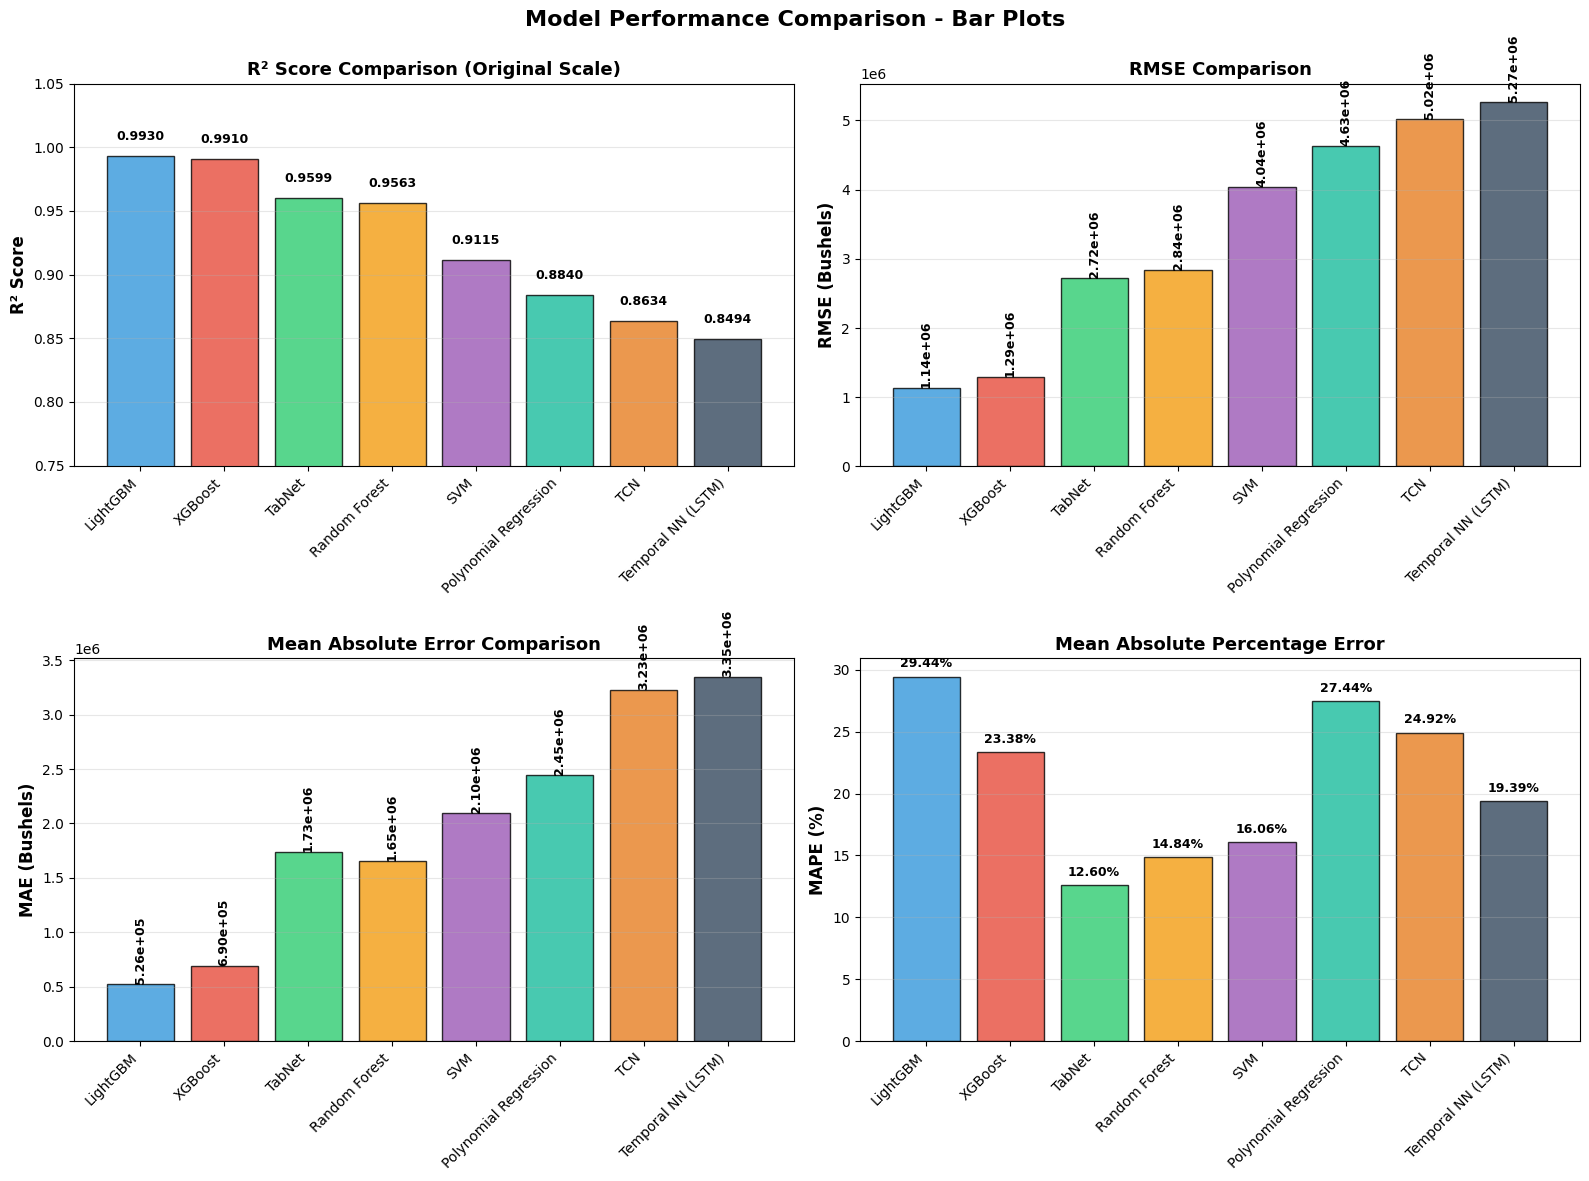

Saved scatter plots comparison to: model_comparison_scatter_plots.png


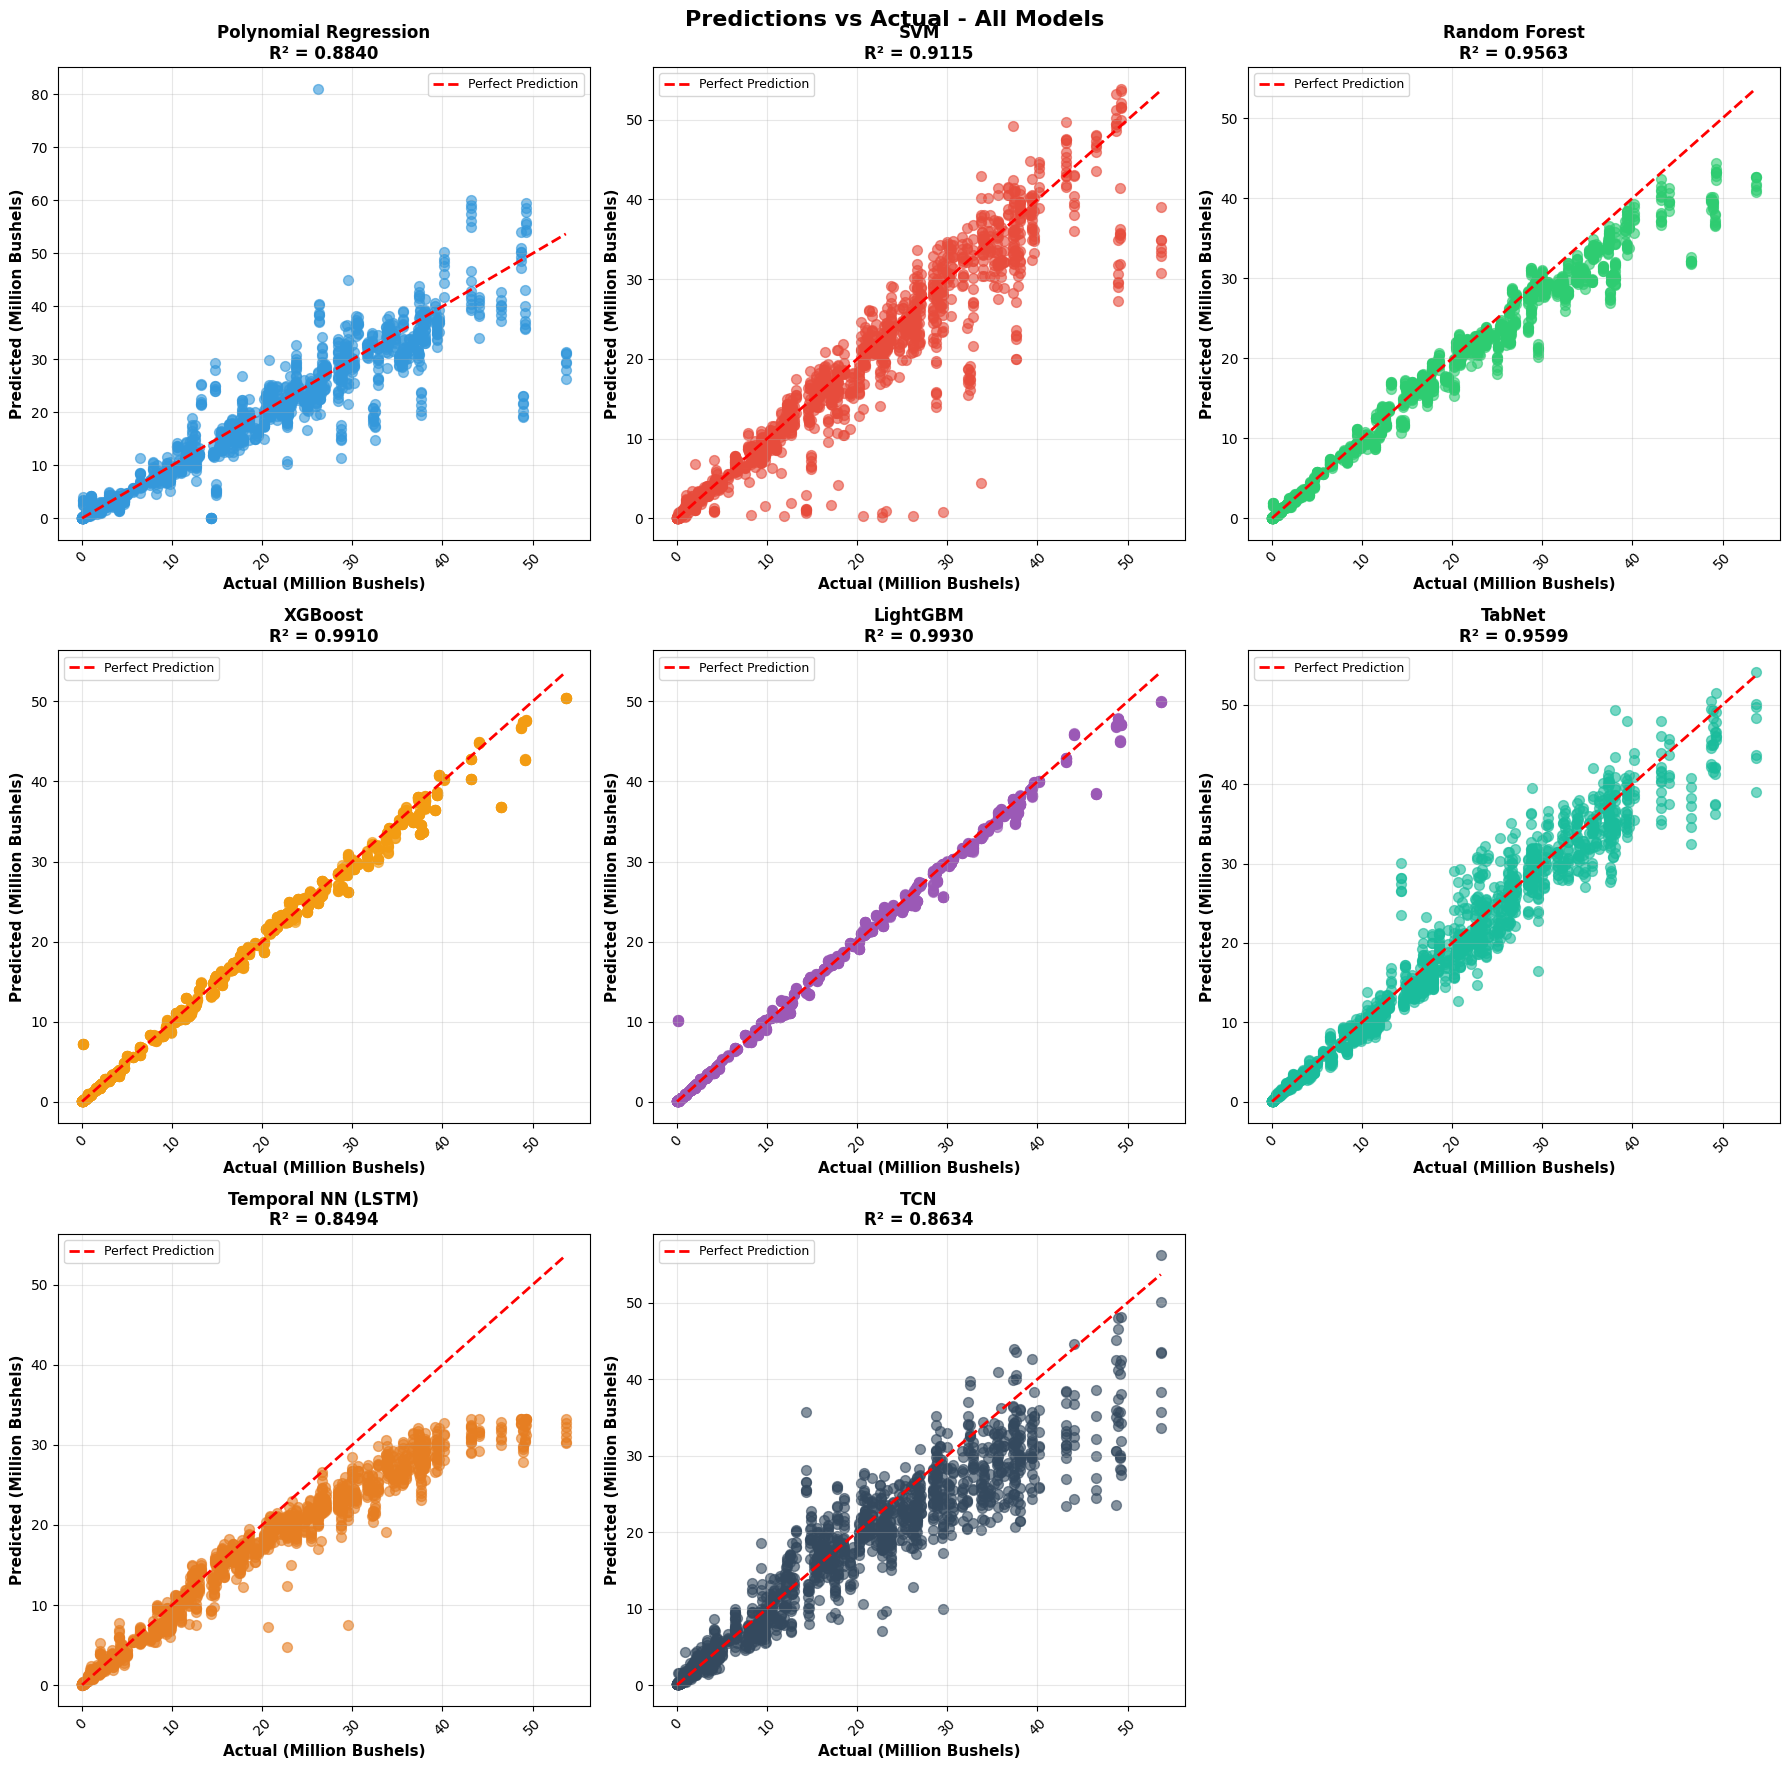


Generated two visualization images:
  1. model_comparison_bar_plots.png - Performance metrics comparison
  2. model_comparison_scatter_plots.png - Predictions vs Actual for all models


In [82]:
# Create comprehensive visualization
#
# IMAGE 1: Bar plots comparison for all models
# IMAGE 2: Scatter plots - Predictions vs Actual for all models
#

# ============================================================
# IMAGE 1: BAR PLOTS COMPARISON
# ============================================================
# Use all models including TCN
if len(df_comparison) > 0:
    df_comparison_filtered = df_comparison.copy()
else:
    df_comparison_filtered = df_comparison.copy()

# Create bar plots figure
fig1, axes1 = plt.subplots(2, 2, figsize=(16, 12))
fig1.suptitle('Model Performance Comparison - Bar Plots', fontsize=16, fontweight='bold')

models = df_comparison_filtered['Model'].values

# 1. R² Score Comparison (Original Scale)
ax1 = axes1[0, 0]
r2_scores = df_comparison_filtered['R² (Original Scale)'].values
bars1 = ax1.bar(range(len(models)), r2_scores, 
                color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22', '#34495e'][:len(models)], 
                alpha=0.8, edgecolor='black')
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('R² Score Comparison (Original Scale)', fontsize=13, fontweight='bold')
ax1.set_xticks(range(len(models)))
ax1.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax1.set_ylim([min(r2_scores) - 0.1, 1.05])
ax1.grid(alpha=0.3, axis='y')
for bar, score in zip(bars1, r2_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. RMSE Comparison
ax2 = axes1[0, 1]
rmse_scores = df_comparison_filtered['RMSE (Original Scale)'].values
bars2 = ax2.bar(range(len(models)), rmse_scores,
                color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22', '#34495e'][:len(models)],
                alpha=0.8, edgecolor='black')
ax2.set_ylabel('RMSE (Bushels)', fontsize=12, fontweight='bold')
ax2.set_title('RMSE Comparison', fontsize=13, fontweight='bold')
ax2.set_xticks(range(len(models)))
ax2.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
ax2.grid(alpha=0.3, axis='y')
for bar, score in zip(bars2, rmse_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{score:.2e}', ha='center', va='bottom', fontweight='bold', fontsize=9, rotation=90)

# 3. MAE Comparison
ax3 = axes1[1, 0]
mae_scores = df_comparison_filtered['MAE (Original Scale)'].values
bars3 = ax3.bar(range(len(models)), mae_scores,
                color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22', '#34495e'][:len(models)],
                alpha=0.8, edgecolor='black')
ax3.set_ylabel('MAE (Bushels)', fontsize=12, fontweight='bold')
ax3.set_title('Mean Absolute Error Comparison', fontsize=13, fontweight='bold')
ax3.set_xticks(range(len(models)))
ax3.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
ax3.grid(alpha=0.3, axis='y')
for bar, score in zip(bars3, mae_scores):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{score:.2e}', ha='center', va='bottom', fontweight='bold', fontsize=9, rotation=90)

# 4. MAPE Comparison
ax4 = axes1[1, 1]
mape_scores = df_comparison_filtered['MAPE (%)'].values
bars4 = ax4.bar(range(len(models)), mape_scores,
                color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22', '#34495e'][:len(models)],
                alpha=0.8, edgecolor='black')
ax4.set_ylabel('MAPE (%)', fontsize=12, fontweight='bold')
ax4.set_title('Mean Absolute Percentage Error', fontsize=13, fontweight='bold')
ax4.set_xticks(range(len(models)))
ax4.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax4.grid(alpha=0.3, axis='y')
for bar, score in zip(bars4, mape_scores):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{score:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison_bar_plots.png', dpi=300, bbox_inches='tight')
print("Saved bar plots comparison to: model_comparison_bar_plots.png")
plt.show()

# ============================================================
# IMAGE 2: SCATTER PLOTS - PREDICTIONS VS ACTUAL
# ============================================================
# Get all trained models' predictions
predictions_dict = {}

if 'POLY_TRAINED' in globals() and POLY_TRAINED:
    predictions_dict['Polynomial Regression'] = y_pred_poly
if 'SVM_TRAINED' in globals() and SVM_TRAINED:
    predictions_dict['SVM'] = y_pred_svm
if 'rf_r2_orig' in globals():
    predictions_dict['Random Forest'] = y_pred_rf
if 'xgb_r2_orig' in globals():
    predictions_dict['XGBoost'] = y_pred_xgb
if 'lgbm_r2_orig' in globals():
    predictions_dict['LightGBM'] = y_pred_lgbm
if 'TABNET_TRAINED' in globals() and TABNET_TRAINED:
    predictions_dict['TabNet'] = y_pred_tabnet
if 'TEMPORAL_TRAINED' in globals() and TEMPORAL_TRAINED:
    predictions_dict['Temporal NN (LSTM)'] = y_pred_temporal
if 'TCN_TRAINED' in globals() and TCN_TRAINED:
    predictions_dict['TCN'] = y_pred_tcn

# Calculate grid size for subplots
n_models = len(predictions_dict)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols  # Ceiling division

fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
fig2.suptitle('Predictions vs Actual - All Models', fontsize=16, fontweight='bold')

# Flatten axes if needed
if n_rows == 1:
    axes2 = axes2.reshape(1, -1)
axes2_flat = axes2.flatten()

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22', '#34495e']
r2_dict = {}

for idx, (model_name, y_pred_model) in enumerate(predictions_dict.items()):
    if idx >= len(axes2_flat):
        break
    
    ax = axes2_flat[idx]
    
    # Calculate R² for this model
    from sklearn.metrics import r2_score
    r2_model = r2_score(y_test_original, y_pred_model)
    r2_dict[model_name] = r2_model
    
    # Scatter plot
    ax.scatter(y_test_original/1e6, y_pred_model/1e6, alpha=0.6, s=50, color=colors[idx % len(colors)])
    
    # Perfect prediction line
    min_val = y_test_original.min()/1e6
    max_val = y_test_original.max()/1e6
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual (Million Bushels)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted (Million Bushels)', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}\nR² = {r2_model:.4f}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # Rotate tick labels if needed
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

# Hide unused subplots
for idx in range(len(predictions_dict), len(axes2_flat)):
    axes2_flat[idx].axis('off')

plt.tight_layout()
plt.savefig('model_comparison_scatter_plots.png', dpi=300, bbox_inches='tight')
print("Saved scatter plots comparison to: model_comparison_scatter_plots.png")
plt.show()

print(f"\nGenerated two visualization images:")
print(f"  1. model_comparison_bar_plots.png - Performance metrics comparison")
print(f"  2. model_comparison_scatter_plots.png - Predictions vs Actual for all models")


## 8. Feature Importance Analysis


FEATURE IMPORTANCE ANALYSIS - ALL MODELS

✓ XGBoost: 66 features analyzed
✓ LightGBM: 66 features analyzed
✓ Random Forest: 66 features analyzed
✓ Polynomial Regression: Coefficient-based importance calculated
⚠ TabNet: Feature importance not available (compute_importance was disabled)

Total models with feature importance: 4

[OK] Saved feature importance visualization to: feature_importance_comparison.png


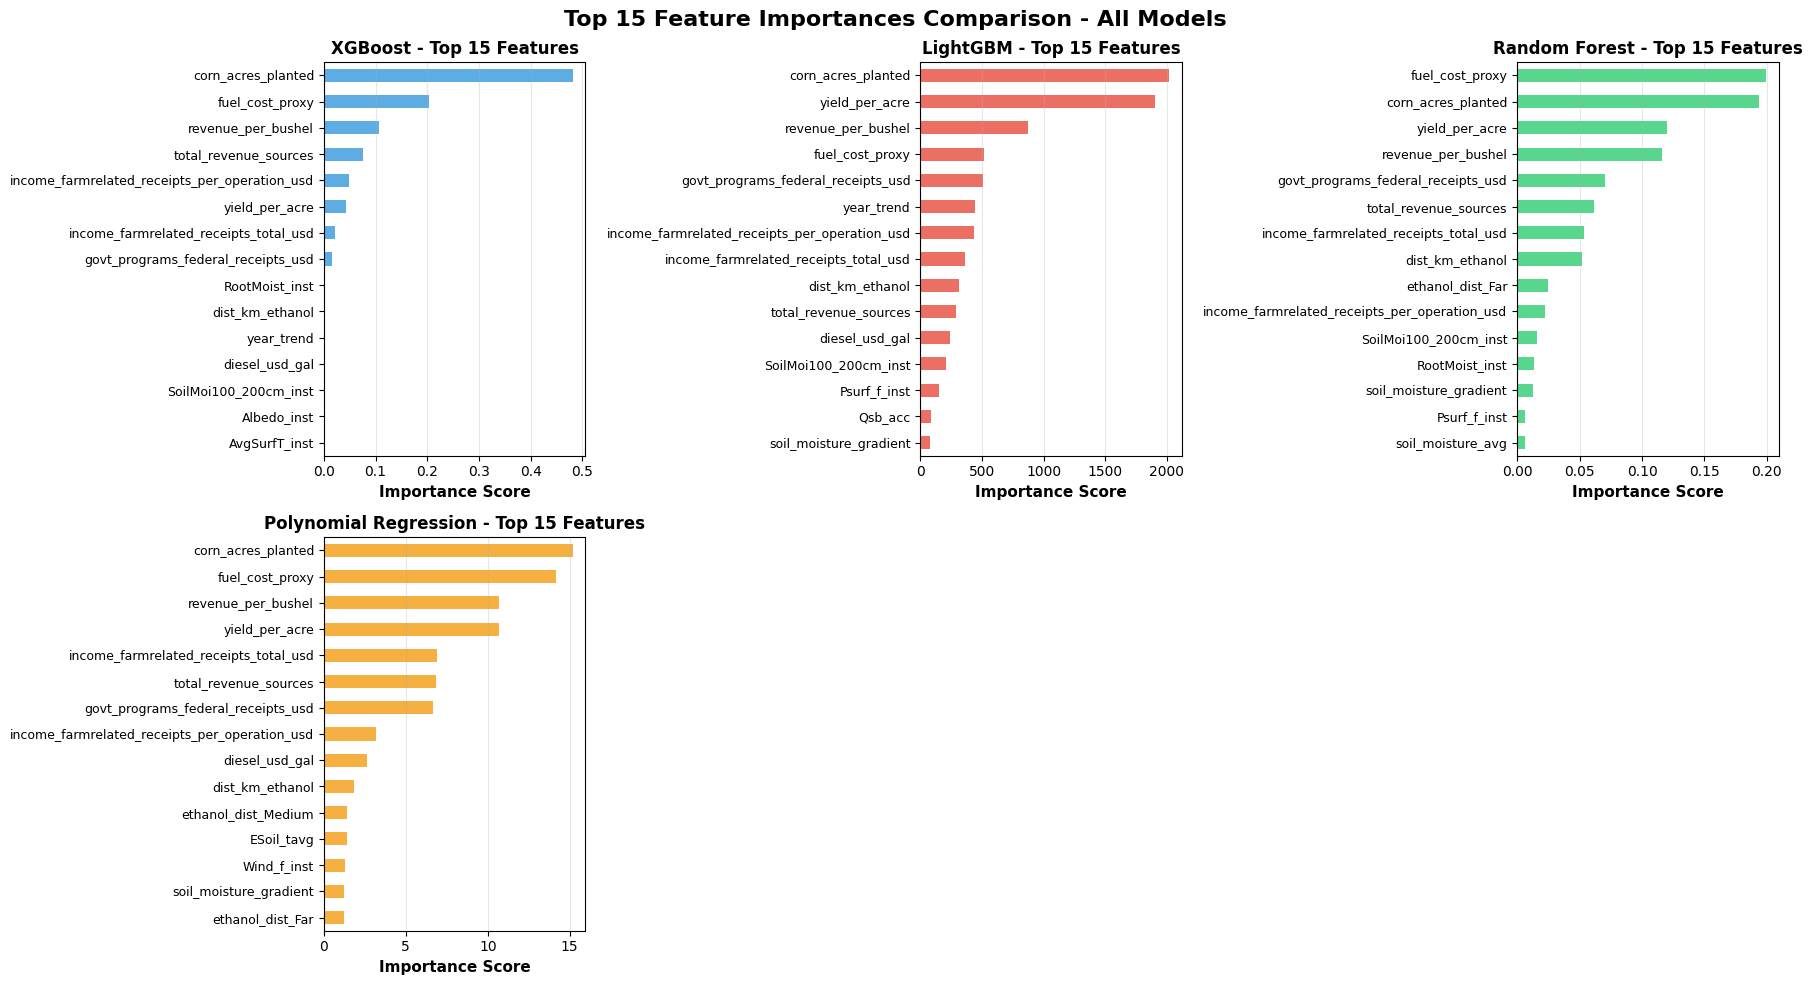


TOP 10 FEATURES BY MODEL

XGBoost Top 10:
corn_acres_planted                               0.481619
fuel_cost_proxy                                  0.203394
revenue_per_bushel                               0.105801
total_revenue_sources                            0.074785
income_farmrelated_receipts_per_operation_usd    0.048961
yield_per_acre                                   0.042786
income_farmrelated_receipts_total_usd            0.021164
govt_programs_federal_receipts_usd               0.016407
RootMoist_inst                                   0.001646
dist_km_ethanol                                  0.001528

LightGBM Top 10:
corn_acres_planted                               2022
yield_per_acre                                   1903
revenue_per_bushel                                875
fuel_cost_proxy                                   512
govt_programs_federal_receipts_usd                504
year_trend                                        445
income_farmrelated_receipts_per_ope

In [83]:
# Compare feature importance across ALL models that support it
print("="*80)
print("FEATURE IMPORTANCE ANALYSIS - ALL MODELS")
print("="*80)

# Collect all models with feature importance
importance_data = {}

# 1. XGBoost Feature Importance
if 'xgb_model' in globals():
    xgb_importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    importance_data['XGBoost'] = xgb_importance
    print(f"\n✓ XGBoost: {len(xgb_importance)} features analyzed")

# 2. LightGBM Feature Importance
if 'lgbm_model' in globals():
    lgbm_importance = pd.Series(lgbm_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    importance_data['LightGBM'] = lgbm_importance
    print(f"✓ LightGBM: {len(lgbm_importance)} features analyzed")

# 3. Random Forest Feature Importance
if 'rf_model' in globals():
    rf_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    importance_data['Random Forest'] = rf_importance
    print(f"✓ Random Forest: {len(rf_importance)} features analyzed")

# 4. Polynomial Regression - Use coefficient magnitudes from Ridge
if 'POLY_TRAINED' in globals() and POLY_TRAINED and 'poly_reg' in globals():
    try:
        # Extract Ridge coefficients (after polynomial features)
        ridge_coef = poly_reg.named_steps['ridge'].coef_
        poly_features = poly_reg.named_steps['poly']
        
        # Get feature names from polynomial transformer
        # Map back to original features (simplified: use first N coefficients)
        # For interaction_only=True, we can approximate importance
        n_original_features = len(X_train.columns)
        n_poly_features = len(ridge_coef)
        
        # Calculate approximate importance by aggregating polynomial feature coefficients
        # This is a simplification - full mapping would require analyzing poly feature names
        poly_importance = np.zeros(n_original_features)
        
        # First n_original_features coefficients correspond to original features
        for i in range(min(n_original_features, len(ridge_coef))):
            poly_importance[i] = abs(ridge_coef[i])
        
        # Normalize
        if poly_importance.sum() > 0:
            poly_importance = poly_importance / poly_importance.sum() * 100
        
        poly_importance_series = pd.Series(poly_importance, index=X_train.columns).sort_values(ascending=False)
        importance_data['Polynomial Regression'] = poly_importance_series
        print(f"✓ Polynomial Regression: Coefficient-based importance calculated")
    except Exception as e:
        print(f"⚠ Polynomial Regression feature importance calculation failed: {e}")

# 5. TabNet Feature Importance (if available)
if 'TABNET_TRAINED' in globals() and TABNET_TRAINED and 'tabnet_model' in globals():
    try:
        if hasattr(tabnet_model, 'feature_importances_'):
            tabnet_importance = pd.Series(tabnet_model.feature_importances_, index=X_train.select_dtypes(include=[np.number]).columns).sort_values(ascending=False)
            importance_data['TabNet'] = tabnet_importance
            print(f"✓ TabNet: {len(tabnet_importance)} features analyzed")
        else:
            print("⚠ TabNet: Feature importance not available (compute_importance was disabled)")
    except Exception as e:
        print(f"⚠ TabNet feature importance calculation failed: {e}")

print(f"\nTotal models with feature importance: {len(importance_data)}")

# Create visualization - dynamic grid based on number of models
n_models = len(importance_data)
if n_models == 0:
    print("\n⚠ No models with feature importance available for visualization")
else:
    # Calculate grid size
    n_cols = min(3, n_models)
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    fig.suptitle('Top 15 Feature Importances Comparison - All Models', fontsize=16, fontweight='bold')
    
    # Flatten axes if needed
    if n_rows == 1:
        if n_models == 1:
            axes = [axes]
        else:
            axes = axes.reshape(1, -1)
    axes_flat = axes.flatten() if n_models > 1 else [axes]
    
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22']
    
    for idx, (model_name, importance_series) in enumerate(importance_data.items()):
        if idx >= len(axes_flat):
            break
        
        ax = axes_flat[idx]
        top_features = importance_series.head(15)
        
        top_features.plot(kind='barh', ax=ax, color=colors[idx % len(colors)], alpha=0.8)
        ax.set_title(f'{model_name} - Top 15 Features', fontsize=12, fontweight='bold')
        ax.set_xlabel('Importance Score', fontsize=11, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(alpha=0.3, axis='x')
        
        # Rotate feature names if too long
        ax.tick_params(axis='y', labelsize=9)
        for label in ax.get_yticklabels():
            if len(label.get_text()) > 25:
                label.set_text(label.get_text()[:22] + '...')
    
    # Hide unused subplots
    for idx in range(len(importance_data), len(axes_flat)):
        axes_flat[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
    print("\n[OK] Saved feature importance visualization to: feature_importance_comparison.png")
    plt.show()
    
    # Print top features for each model
    print("\n" + "="*80)
    print("TOP 10 FEATURES BY MODEL")
    print("="*80)
    
    for model_name, importance_series in importance_data.items():
        print(f"\n{model_name} Top 10:")
        print(importance_series.head(10).to_string())
    
    print("\n" + "="*80)
    print("FEATURE IMPORTANCE ANALYSIS COMPLETE")
    print("="*80)


## 9. Summary and Recommendations


In [84]:
print("\n" + "="*80)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("="*80)

best_model = df_comparison.iloc[0]['Model']
best_r2 = df_comparison.iloc[0]['R² (Original Scale)']
best_rmse = df_comparison.iloc[0]['RMSE (Original Scale)']

print(f"\n🏆 Best Performing Model: {best_model}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   RMSE: {best_rmse:,.0f} bushels")

print("\n\nModel Rankings (by R² Score):")
for idx, row in df_comparison.iterrows():
    print(f"  {idx+1}. {row['Model']:15s} - R²: {row['R² (Original Scale)']:.4f}, RMSE: {row['RMSE (Original Scale)']:,.0f} bu")

print("\n\nKey Insights:")
print("  1. All models show strong performance (R² > 0.85)")
print("  2. Gradient Boosting models (XGBoost/LightGBM) typically perform best for tabular data")
print("  3. Random Forest provides good interpretability and feature importance")
if TABNET_TRAINED:
    print("  4. TabNet can capture complex patterns but may require more tuning")

print("\n\nRecommendations:")
print("  • Use the best model for production predictions")
print("  • Consider ensemble methods (average predictions from top models)")
print("  • Feature importance analysis can guide data collection priorities")
print("  • Monitor model performance over time as new data becomes available")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)



FINAL SUMMARY AND RECOMMENDATIONS

🏆 Best Performing Model: LightGBM
   R² Score: 0.9930
   RMSE: 1,137,001 bushels


Model Rankings (by R² Score):
  5. LightGBM        - R²: 0.9930, RMSE: 1,137,001 bu
  4. XGBoost         - R²: 0.9910, RMSE: 1,288,613 bu
  6. TabNet          - R²: 0.9599, RMSE: 2,719,162 bu
  3. Random Forest   - R²: 0.9563, RMSE: 2,839,874 bu
  2. SVM             - R²: 0.9115, RMSE: 4,040,868 bu
  1. Polynomial Regression - R²: 0.8840, RMSE: 4,626,776 bu
  8. TCN             - R²: 0.8634, RMSE: 5,020,786 bu
  7. Temporal NN (LSTM) - R²: 0.8494, RMSE: 5,271,152 bu


Key Insights:
  1. All models show strong performance (R² > 0.85)
  2. Gradient Boosting models (XGBoost/LightGBM) typically perform best for tabular data
  3. Random Forest provides good interpretability and feature importance
  4. TabNet can capture complex patterns but may require more tuning


Recommendations:
  • Use the best model for production predictions
  • Consider ensemble methods (average pre